# How to Design Equiripple Filters in Julia?

[JuliaCon (London)](http://juliacon.org/2018/), July 8, 2018. 

Tom Krauss.

Signal Processing / Software Engineer at [Epiq Solutions](http://epiqsolutions.com) (Schaumburg Illinois). 

PhD in Electrical Engineering (Purdue).

Relevant background: 
* previously worked on filter design at MathWorks
* got a masters at Cornell advised by Tom Parks

## FIR filter background
$y[n] = \sum_{m=0}^{L-1}h[m]x[n-m]$
![block diagram](fir_filter_block_diagram.png)
$Y(\omega) = \sum_{n=-\infty}^{\infty}y[n]e^{-jn\omega} = H(\omega)X(\omega)$

## FIR filters in Julia. Low pass filter example

Ideal "brick wall" frequency response:

$H(\omega)=1$ for $|\omega| \le 2\pi f_c$

$H(\omega)=0$ for $|\omega| > 2\pi f_c$

Time domain impulse response:

$h[n]=\frac{1}{2\pi}\int_{-\pi}^{\pi}H(\omega)e^{jn\omega}d\omega$

$= 2 f_c \text{sinc}(2 f_c n)$

Infinite duration! Not realizable.

In [45]:
using PyPlot

function plot_response(h, fc, nfft=2000)
    L = length(h)
    M = (L-1)÷2
    h_zero_pad = zeros(nfft)
    h_zero_pad[1:M+1] = h[end-M:end]
    h_zero_pad[end-M+1:end] = h[1:M]
    H = real.(fftshift(fft(h_zero_pad)))
    n = -M : M

    subplot(121)
    plot( n, h, ".-")
    title("Time domain")
    xlabel("n")
    grid()
    
    subplot(122)
    f = ((-nfft÷2):(nfft÷2-1))/nfft
    Hideal(f) = (abs.(collect(f)).<=fc)*1
    plot(2f, Hideal(f), label="\$H(f)\$ ideal")
    plot(2f, H, label="\$H(f)\$")
    legend(loc="best") # fontsize="small")
    title("Frequency domain")
    xlabel("\$2f\$")
    setp(gca(), xlim=(0,1), ylim=(-0.2, 1.2))
    grid()
end

plot_response (generic function with 2 methods)

### Simple approach - truncate inverse to finite length
Although optimal in least-squares sense, it exhibits a lot of ringing (i.e. overshoot).

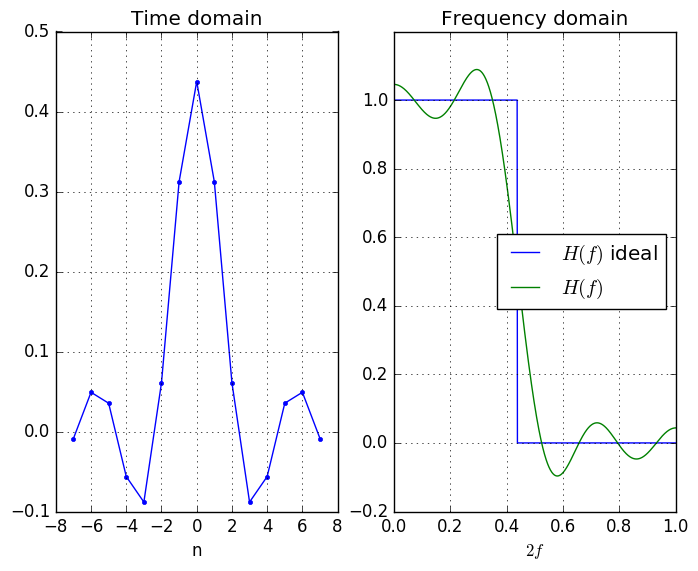

In [46]:
fc = 0.21875  # cutoff frequency
n = -7 : 7
h = 2fc * sinc.(2fc * n)
plot_response(h, fc)

### DSP.jl's "FIRWindow" - smooths the transition
A lot of trial and error, and no longer optimal in any way.

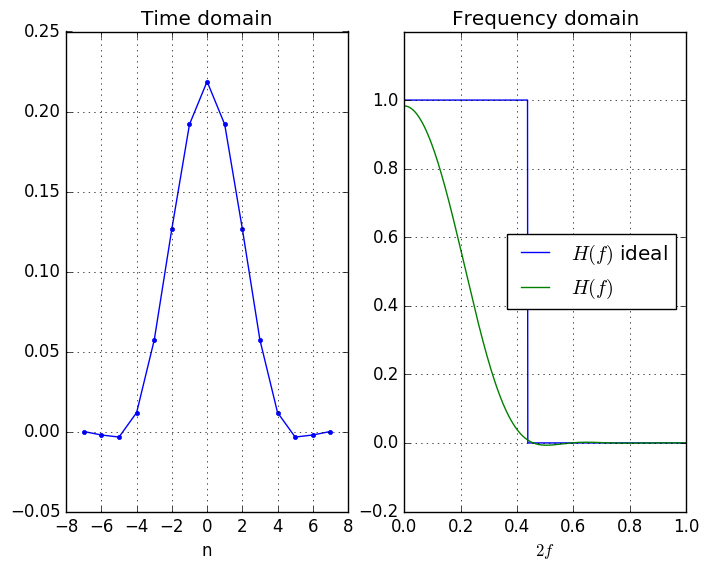

In [47]:
using DSP
ftype = Lowpass(fc)
proto = FIRWindow(hanning(15), scale=false)  # apply window to "smooth" ringing in frequency
h_window = digitalfilter(ftype, proto)
plot_response(h_window, fc) # stop band is much better, but pass band is much worse here - heuristic

# PARKS-MCCLELLAN ALGORITHM

![jim mcclellan](JMcRemezCards.png)
Jim McClellan with FORTRAN card decks.
"The date 3-3-3 is 3-March-1973 which was the final version of Remez prior to my PhD defense."


## Chebyshev approximation
Minimize the *maximum* error. Introduces a "transition" band between the passband and stopband.

**Alternation theorem** from Chebyshev approximation theory states that the filter is optimal if (and only if) the error alternates (positive, then negative, then positive, etc) at its maximum at least $M+2$ times (for filter length $L = 2M + 1$)

**references**
["a personal history"](https://ieeexplore.ieee.org/document/1406492/) [doug jones talk](https://cnx.org/exports/0bb211fb-4a74-4efc-8a90-291cef969b75@3.pdf/parks-mcclellan-fir-filter-design-3.pdf)

## High-level Overview of Parks-McClellan Algorithm

1. Start with initial, uniformly spaced set of "extremal" frequencies - guesses as to where the error is maximal. 
2. Make the error equiripple on that set - it is not maximal at first.
3. Change the extremal frequencies in the direction of increasing error. 
4. If the error is maximal on the extremal frequencies, we are done. Else, goto 2.

It's like squeezing a balloon.

In [43]:
using PyPlot

f1, f2 = 0.375, 0.5
hh = [remez(15, vec([0 f1 f2 1.0]), vec([1.0 0.0]); Hz=2.0, maxiter=1)'
      remez(15, vec([0 f1 f2 1.0]), vec([1.0 0.0]); Hz=2.0, maxiter=2)'
      remez(15, vec([0 f1 f2 1.0]), vec([1.0 0.0]); Hz=2.0, maxiter=3)'
      remez(15, vec([0 f1 f2 1.0]), vec([1.0 0.0]); Hz=2.0, maxiter=4)']

function plot_equiripple_response(niter=4)
    nfft = 2000
    h = hh[niter,:]
    L = length(h)
    M = (L-1)÷2
    h_zero_pad = zeros(nfft)
    h_zero_pad[1:M+1] = h[end-M:end]
    h_zero_pad[end-M+1:end] = h[1:M]
    H = real.(fftshift(fft(h_zero_pad)))
    
    delta_per_iter = [0.014948449582873934 0.0744428511389897 0.0881963947109857 0.088359263108882]
    iext = [1  15  29  43  57  71  85  99  114  115
    1  18  36  49  50  64  81  97  114  115
    1  21  40  49  50  59  77  96  114  115
    1  22  40  49  50  59  76  95  114  115]
    extremals = [0  109  219  328  555  664  773  883  1000
                 0  133  273  375  500  609  742  867  1000
                 0  156  305  375  500  570  711  859  1000
                 0  164  305  375  500  570  703  852  1000]+1000
    delta = delta_per_iter[niter]
    f = ((-nfft÷2):(nfft÷2-1))/nfft
    plot([0, f1, f1, f2, 1.0], [1, 1, NaN, 0, 0], label="\$H(f)\$ ideal")
    plot(2f, H, label="\$H(f)\$")
    plot([0, f1], [1+delta, 1+delta], "r:")
    plot([0, f1], [1-delta, 1-delta], "r:")
    plot([f2, 1], [delta, delta], "r:")
    plot([f2, 1], [-delta, -delta], "r:")
    #extremals = vec([0  164  304  375  500  570  703  851  1000])+1000
    plot(2f[extremals[niter,:]], H[extremals[niter,:]], "*", markersize=10, label="alternating error")
    title("Frequency domain, $niter iterations, error=$delta")
    legend(loc="best")
    xlabel("\$2f\$")
    setp(gca(), xlim=(-0.02,1.02), ylim=(-0.2, 1.2))
    grid()
    return H
end


plot_equiripple_response (generic function with 2 methods)

### FIRST ITERATION
Here, $length(h) = L = 15 = 2M + 1$ ==> $M = 7$

Alternation theorem: must have $M + 2 = 9$ "alternations" where the error is maximum.

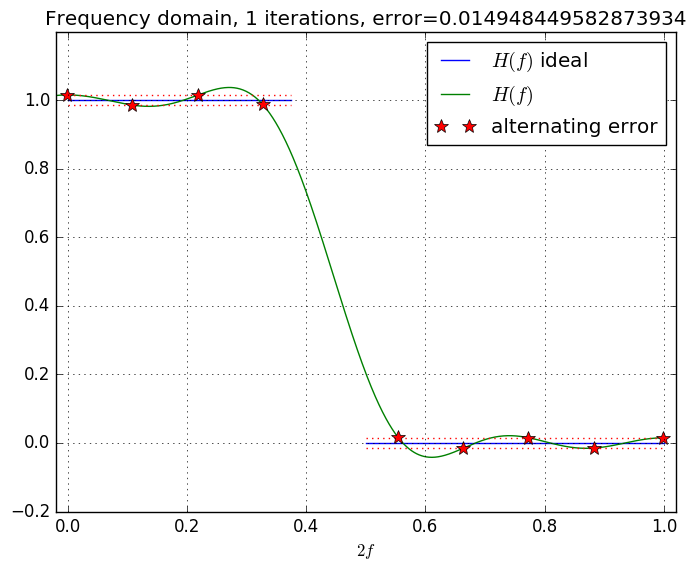

In [44]:
plot_equiripple_response(1);

### SECOND ITERATION

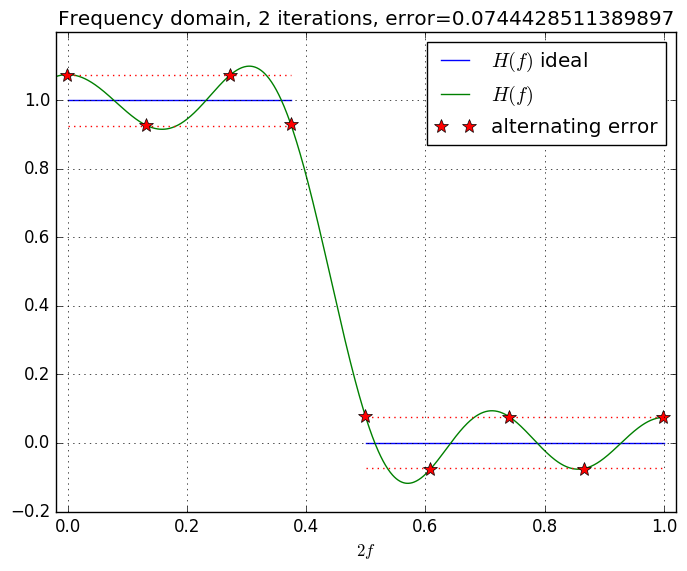

In [36]:
plot_equiripple_response(2);

### THIRD ITERATION

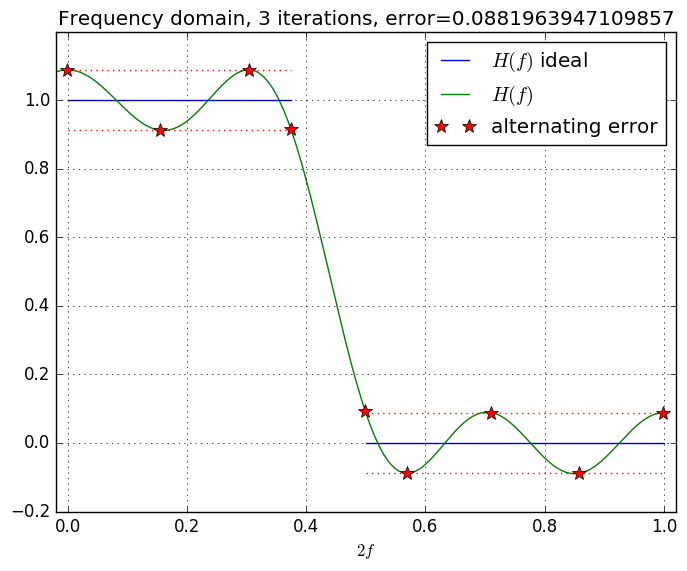

In [37]:
plot_equiripple_response(3);

### FOURTH ITERATION - CONVERGED!

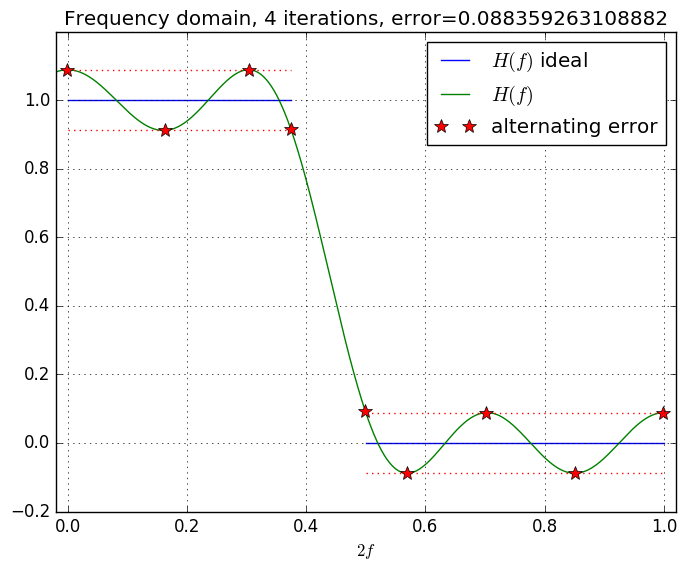

In [38]:
plot_equiripple_response(4);
# here, length(h) = L = 15 = 2M + 1 ==> M = 7
# Alternation theorem: must have M + 2 = 9 "alternations" where the error is maximum.

# REMEZ FUNCTION IN JULIA
Merged to DSP.jl package, July 2018.

Efforts by myself and other contributors - special thanks to [Martin Holters](https://github.com/martinholters) for reviews and contributions. 

[julia source "remez_fir.jl"](https://github.com/JuliaDSP/DSP.jl/blob/master/src/Filters/remez_fir.jl)

Functionally equivalent, pure Julia translation of scipy.signal's C implementation.

Got rid of some of the "goto" statements - extremal update portion has very hairy logic and still has a lot of "goto" statements.

## How to call "remez" in Julia
```
using DSP
h = remez(numtaps, bands, desired; Hz=Hz)
```

For example:

```
h = remez(15, vec([0 0.375 0.5 1.0]), vec([1.0 0.0]); Hz=2.0)
```
<img src="remez_function_inputs2.png" alt="remez_specs" width="600">



## Comparison with C implementation (DSPRemezWrap.jl)
<img src="remez_time_julia_c_compare.png" alt="run_time_compare" width="800">


# Conclusion
Go forth and design filters - with "remez" in DSP.jl!